In [119]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
import lightgbm as lgb

In [17]:
#Load data: Load both the merged data and the original unaltered data 
merged_file = '../DataSet/merged_data2.csv'
data = pd.read_csv(merged_file, parse_dates =[2])

#market_file = '../DataSet/market_clean.csv'
#data = pd.read_csv(market_file, parse_dates =[1])

#news_file = '../DataSet/news_train_df.csv'
#news_data = pd.read_csv(news_file, parse_dates =[1])

In [18]:
#Combine mean of news data information by day
data = data.dropna(axis = 0, how = 'any').groupby('assetName').resample('d', on = 'time').mean().dropna(axis = 0, how = 'any')
data = data.reset_index(drop = False)

In [57]:
data.columns
data.assetName.unique()

array(['21Vianet Group Inc', '2U Inc', '3Com Corp', ..., 'rue21 Inc',
       'thinkorswim Group Inc', 'tw telecom Inc'], dtype=object)

In [102]:
#Create new features to help in modeling data

#Calculate asset name values
array_idx = dict(zip(data.assetName.unique(), np.arange(data.assetName.nunique())))
data['assetNameT'] = data['assetName'].map(array_idx)

#Calculate a rolling average of 5 and 10 days over the stock opening price
open5 = data.groupby('assetName')['open'].rolling(window = 5).mean()
open10 = data.groupby('assetName')['open'].rolling(window = 10).mean()

#Calculate daily log return
logr = np.log10(data.close/data.open)

#Return Prev10 Raw rolling average over 5 and 10 days
r5 = data.groupby('assetName')['returnsOpenPrevRaw10'].rolling(window = 5).mean()
r10 = data.groupby('assetName')['returnsOpenPrevRaw10'].rolling(window = 10).mean()

#Sentiment class average over 5 and 10 data points
sent5 = data.groupby('assetName')['sentimentClass'].rolling(window = 5).mean()
sent10 = data.groupby('assetName')['sentimentClass'].rolling(window = 10).mean()

#Insert data into dataframe for use in modeling
data['open5'] = open5.values
data['open10'] = open10.values
data['r5'] = r5.values
data['r10'] = r10.values
data['logr'] = logr
data['sent5'] = sent5.values
data['sent10'] = sent10.values

In [103]:
#Choose features to use in model
features = ['volume', 'close', 'open', 'returnsClosePrevRaw1',
       'returnsOpenPrevRaw1', 'returnsClosePrevMktres1',
       'returnsOpenPrevMktres1', 'returnsClosePrevRaw10',
       'returnsOpenPrevRaw10', 'returnsClosePrevMktres10',
       'returnsOpenPrevMktres10',
        'sentenceCount', 'wordCount', 'sentimentClass', 'sentimentNegative', 'sentimentNeutral',
       'sentimentPositive', 'sentimentWordCount', 'noveltyCount12H',
       'noveltyCount24H', 'noveltyCount3D', 'noveltyCount5D', 'noveltyCount7D',
       'volumeCounts12H', 'volumeCounts24H', 'volumeCounts3D',
       'volumeCounts5D', 'volumeCounts7D' ,
        'open5', 'open10', 'r5', 'r10', 'logr', 'sent5', 'sent10', 'assetNameT']

In [104]:
#Set up X and y for modeling
X = data[features]
y = (data.returnsOpenNextMktres10 >= 0).values
y = y.astype(int)

#Set up additional parameters to calculate final metric used in Two Sigma competition
universe = data.universe
r = data.returnsOpenNextMktres10
day = data.time.dt.date

In [105]:
#Create train and test sets
X_train, X_test, y_train, y_test, _, univ_test, _, r_test, _, day_test = \
       train_test_split(X, y, universe, r, day, test_size = 0.3, random_state = 42)

In [106]:
print(len(y_train))
print(len(y_test))

379311
162562


In [107]:
#Set up model and determine best parameters for XGBClassifier
gb = XGBClassifier()
#params = {'n_estimators': [200, 500, 1000, 2000, 4000],
#          'max_depth': [4, 6, 8, 10],
#          'learning_rate': [.001, .01, 0.1, 0.3],
#          'booster': ['gbtree', 'gblinear', 'dart']}
params = {'booster': 'gbtree',
          'learning_rate': 0.1,
          'max_depth': 6,
           'n_estimators': 100,
          'n_jobs': 4}
#gb_cv = GridSearchCV(gb, params, cv = 5, n_jobs = -1)

#Preform grid search to find best fit parameters using XGBClassifier
#gb_cv.fit(X_train, y_train)

#Show the best parameters and best score value determined from the grid search
#print(gb_cv.best_params_)
#print(gb_cv.best_score_)

In [108]:
#Initialize model with optimized parameters
model = XGBClassifier(**params)

In [116]:
%%time
#Fit model to training data
gb_model = model.fit(X_train, y_train)

Wall time: 1min 24s


In [110]:
#Collection prediction values for classification
y_pred = model.predict_proba(X_test)
predictions = [round(value[1]) for value in y_pred]
print(y_pred[20:30])

[[0.5365983  0.4634017 ]
 [0.4345715  0.5654285 ]
 [0.5031378  0.4968622 ]
 [0.48540175 0.51459825]
 [0.4219814  0.5780186 ]
 [0.54353535 0.45646465]
 [0.558565   0.44143495]
 [0.47753066 0.52246934]
 [0.5518733  0.44812664]
 [0.5396979  0.46030208]]


In [111]:
#Calculate accuracy score for the predictions
accuracy = accuracy_score(y_test, predictions)
print('Accuracy: %.4f'%(accuracy))

Accuracy: 0.5602


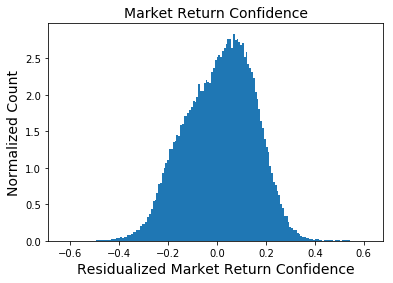

In [142]:
#Plot histogram of prediction results.  Notice, using the Two Sigma scoring metric to calculate the 
#conifidence that returnOpenNextMktres10 is negative or positive.
y_r = y_pred[:,1]*2 - 1
plt.hist(y_r, bins = 'auto', density = True)
plt.xlabel('Residualized Market Return Confidence', fontsize = 14)
plt.ylabel('Normalized Count', fontsize = 14)
plt.title('Market Return Confidence', fontsize = 14)
plt.savefig('ReturnConfidence_fe.png', bbox = 'tight')
plt.show()

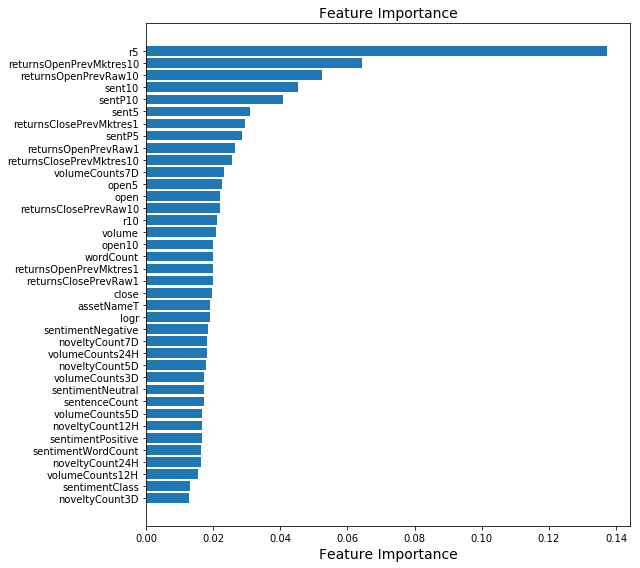

In [140]:
#Display bar graph of feature importance in model
feat_imp = model.feature_importances_
feat = pd.DataFrame()
feat['feature'] = features
feat['importance'] = feat_imp
feat = feat.sort_values('importance')

wide = np.arange(len(feat_imp))
plt.figure(figsize = (9,8))
plt.barh(wide, feat['importance'])
plt.yticks(wide, feat['feature'])
plt.xlabel('Feature Importance', fontsize = 14)
plt.title('Feature Importance', fontsize = 14)
plt.tight_layout()
plt.savefig('FeatureImportance_fe.png', bbox = 'tight')
plt.show()

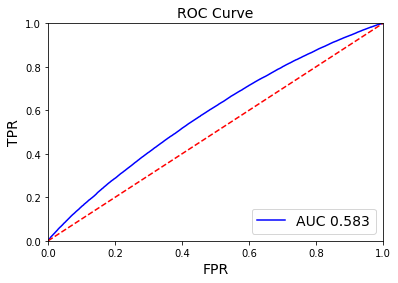

In [141]:
#Plot ROC curve for XGBClassifier model
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:,1])
auc = roc_auc_score(y_test, y_pred[:,1])

plt.plot(fpr, tpr, color = 'blue')
plt.plot([0,1], [0,1], color = 'red', linestyle = '--')
plt.xlabel('FPR', fontsize = 14)
plt.ylabel('TPR', fontsize = 14)
plt.title('ROC Curve', fontsize = 14)
plt.axis([0, 1, 0, 1])
plt.legend(['AUC %.3f'%auc], loc = 'lower right', fontsize = 14)
plt.savefig('ROC_XGBClassifier_fe.png', bbox = 'tight')
plt.show()

In [71]:
#Calculate the metric used Two Sigma competition for scoring

#Clip outliers for the returnsOpenNextMktres10 data
r_test2 = r_test.clip(-1,1)

#Calculate scoring metric
y_int = y_r*univ_test*r_test2
df = pd.DataFrame()

df['day'] = day_test
df['y_int'] = y_int

y_i = df.groupby('day').sum().values.flatten()
mean_i = np.mean(y_i)
std_i = np.std(y_i)

score_gb = mean_i/std_i
print('Score using XGBClassifier %.4f'%(score_gb))


Score using XGBClassifier 0.6138


In [133]:
#Perform light gbm
train_data = lgb.Dataset(X_train, label=y_train)
param = {'num_leaves':100,
         'objective':'binary',
         'max_depth':6,
         'learning_rate':0.1,
         'max_bin':200}

lgb_model = lgb.train(param, train_data, 50)
ypred_lgb = lgb_model.predict(X_test)

In [134]:
predictions2 = [round(value) for value in ypred_lgb]

In [135]:
#Calculate accuracy score for the predictions
accuracy = accuracy_score(y_test, predictions2)
print('Accuracy: %.4f'%(accuracy))

Accuracy: 0.5582


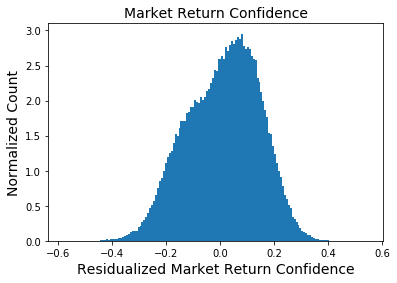

In [136]:
#Plot histogram of prediction results.  Notice, using the Two Sigma scoring metric to calculate the 
#conifidence that returnOpenNextMktres10 is negative or positive.
y_r = ypred_lgb*2 - 1
plt.hist(y_r, bins = 'auto', density = True)
plt.xlabel('Residualized Market Return Confidence', fontsize = 14)
plt.ylabel('Normalized Count', fontsize = 14)
plt.title('Market Return Confidence', fontsize = 14)
plt.savefig('ReturnConfidence.png', bbox = 'tight')
plt.show()

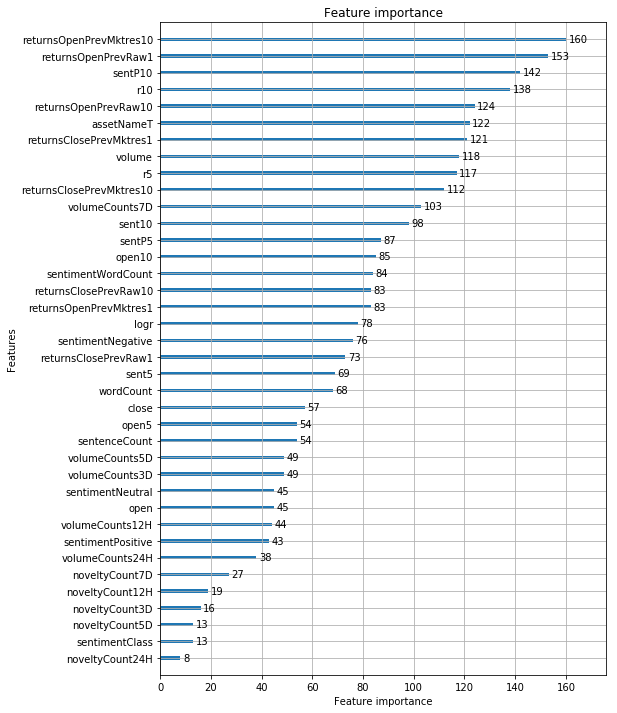

In [137]:
#Display bar graph of feature importance in model
lgb.plot_importance(lgb_model, figsize=(8,12))